In [5]:
from pymongo import MongoClient
from pathlib import Path
import os
from pprint import pprint
import nltk
import matplotlib.pyplot as plt
import pprint
import pywt

import os
import struct
import matplotlib
from scipy import signal
import scipy.fftpack
import numpy as np
import sys
import pymongo
import json

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
client = MongoClient('mongodb://localhost:27017')
testDb = client.testDb

patients = testDb.patients
sessions = testDb.sessions
reports = testDb.reports

In [7]:
def fileName(filePath):
    return (os.path.splitext(os.path.split(filePath)[1]))[0]

def fileExt(filePath):
    try:
        return (os.path.splitext(os.path.split(filePath)[1]))[1]
    except:
        return "Error"

In [25]:
class channel(object):
    def __init__(self,edfFile,label=None,transducer=None,dimensions=None,
                physMin=None,physMax=None,digMin=None,digMax=None,
                 preFilter=None,sampleRate=None,notes=None,channelIndex=None,byteLength=None):
        self.edfFile = edfFile
        self.label = str(label)
        self.sampleRate = int(sampleRate)
        self.transducer = str(transducer)
        self.dimensions = dimensions
        self.physMin = physMin
        self.physMax = physMax
        self.digMin = digMin
        self.digMax = digMax
        self.preFilter = preFilter
        self.notes  = notes
        self.channelIndex = int(channelIndex)
        self.byteLength = byteLength
        #self.indexStart = indexStart
    
    def __str__(self):
        if self.label==None:
            return "None"
        else:
            returnString = ("Label: "+str(self.label) + "\nSample Rate"+str(self.sampleRate)+
            "\nTransducer: "+str(self.transducer)+"\nDimensions: "+str(self.dimensions)+
            "\nphysMin: "+str(self.physMin)+"\nphysMax: "+str(self.physMax)+
            "\ndigMin: "+str(self.digMin) +"\ndigMax: "+str(self.digMax)+ "\npreFilter: "+str(self.preFilter)+
            "\nNotes: "+str(self.notes) + "\nChannelIndex: "+str(self.channelIndex) + "\nbyteLength: "+str(self.byteLength))
        return returnString
    
    def channelData(self,start,duration,channelNumber = 0,sensitivity = 1):
        '''
        Returns data points for desired area
        start: seconds from start of record
        duration: time  of record desired in seconds
        ##########This might be easier to do within original edf class
        Need to change to accomdate FLOATING POINTS !!!!!!!!!!!
        '''
        toReturn = []
        startByte = float(start) * self.sampleRate * 2
        '''
        print("TYPE START: ",type(start))
        print("channel.channelData Sample Rate: ",type(self.sampleRate))
        print("Start: ",start)
        print("START BYTE FROM CHANNEL DATA: ",startByte," Start: ",start," SampleRate: ",self.sampleRate)
        '''
        seekLocation = int(self.channelIndex + int(startByte))  #need to fix this --------------
        #print('Seek Location: ',seekLocation)
        numberOfBytes = int(self.sampleRate) * float(duration) #* 2
        try:
            numberOfBytes = int(numberOfBytes)
        except:
            return "ERROR in numberOfBytes"
        
        self.edfFile.edfRawData.seek(seekLocation)
        for i in range(numberOfBytes):
            try:
                value = struct.unpack('h',self.edfFile.edfRawData.read(2))[0]
                value = value*sensitivity    #Changed this from np.array(value)*sensitivity
                value -= channelNumber*20*sensitivity
            except:
                value = 'E'
            toReturn.append(value)
            #toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2))) 
        return toReturn

    def allChannelData(self):
        toReturn = []
        self.edfFile.edfRawData.seek(self.channelIndex)
        for i in range(int(self.byteLength/2)):
            toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2)))
        return toReturn
        
    def getLabel(self):
        return str(self.label)
    
    def getSampleRate(self):
        return self.sampleRate
    
    def getChannelIndex(self):
        return self.channelIndex
    
    def getTransducer(self):
        return self.transducer

    def getDimensions(self):
        return self.dimensions
    
    def getPhysMin(self):
        return float(self.physMin)
    
    def getPhysMax(self):
        return float(self.physMax)
    
    def getDigMin(self):
        return float(self.digMin)
    
    def getDigMax(self):
        return float(self.digMax)
    
    def getPreFilter(self):
        return self.preFilter
    
    def getNotes(self):
        return self.notes
    
    def getByteLength(self):
        return self.byteLength
    
class edfData(object):
    def __init__(self,fileId):
        self.fileId=fileId
        
    def __str__(self):
        return ("version: " + str(self.version) + "\nPatient Id: "+str(self.patientId) 
                + "\nrecordId" + str(self.recordId) + "\nStart Date: " + str(self.startTime)
                + "\nStart Time: " + str(self.startTime)
                + "\nheader Bytes: " + str(self.headerBytes) +"\nReserve Bytes: " +str(self.reservedBytes)
                + "\nNum Records :" + str(self.nRecords) + "\nNum Signals :" + str(self.nSignals) 
                + "\nDuration: "+ str(self.duration) + "\nFile Size: "+str(self.fileSize))
                
                
    def loadFile(self,filepath):
        self.filePath = filepath
        self.fileSize = os.path.getsize(filepath)
        self.edfRawData = open(filepath,'rb')
        
    def readBitsTest(self):
        self.edfRawData.seek(0)
        bits = self.edfRawData.read(10000)
        self.edfRawData.seek(0)
        print(self.edfRawData.read(10))
        print("Some Bits: "+str(bits))
        return bits
    
    def readSignalHeaderBits(self,bitsIn,nSignals,nBits):
            returnArray = []
            for x in range(nSignals):
                returnArray.append(bitsIn.read(nBits))
            return returnArray
        
    def returnChannelObjects(self):
        return self.channels
    
    def parseEdf(self):
        '''
            This function parses the edf file getting the values of 
            the header fields. It also creates a channel object with 
            information about each channel, including the eeg tracing data from each channel.
        '''
        #Header Fields
        self.version = str(self.edfRawData.read(8))
        self.patientId = str(self.edfRawData.read(80))
        self.recordId = str(self.edfRawData.read(80))
        self.startDate = str(self.edfRawData.read(8))
        self.startTime = str(self.edfRawData.read(8))
        self.headerBytes = int(self.edfRawData.read(8))
        self.reservedBytes = str(self.edfRawData.read(44))
        self.nRecords = int(self.edfRawData.read(8))
        self.duration = float(self.edfRawData.read(8))
        self.nSignals = int(self.edfRawData.read(4))
        
        #Create channel object for each channel
        self.channels = {}
        channelFields = ['labels','transducer','dimensions','physMin','physMax','digMin','digMax',
                        'preFilter','sampleRate','reservedNotes']
        self.channels['labels'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,16)
        self.channels['transducer'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,80)
        self.channels['dimensions'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['physMin'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['physMax'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['digMin'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['digMax'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['preFilter'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,80)
        self.channels['sampleRate'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['reservedNotes'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,32)
        
        self.channelObjects = []
        self.sampleRate = int(self.channels['sampleRate'][0])
        channelDataStart = self.headerBytes
        
    
        #This loop creates and adds channel objects to self.channelObjects
        for i in range(int(self.nSignals)):
            
            channelValues ={'filepath':self.filePath}
            byteLength = int(self.channels['sampleRate'][i])*self.nRecords     #*2
            channelIndex = channelDataStart
            channelDataStart +=byteLength
            
            for j in channelFields:
                try:
                    channelValues[j]=(self.channels[j][i])
                except:
                    channelValues[j] = None
            self.channelObjects.append(
                channel(self,channelValues['labels'],channelValues['transducer'],
                        channelValues['dimensions'],channelValues['physMin'],channelValues['physMax'],
                        channelValues['digMin'],channelValues['digMax'],channelValues['preFilter'],
                        channelValues['sampleRate'],channelValues['reservedNotes'],
                        channelDataStart,byteLength))  #Changed this channelIndex to channelDataStart
    
    
        self.channelSampleRates = channelValues['sampleRate'] 
        self.channelDigMax = channelValues['digMax']
        self.channelDigMin = channelValues['digMin']
        self.channelPhysMax = channelValues['physMax']
        self.channelPhysMin = channelValues['physMin']
            
    def data(self,start,duration):
        sampleData = []
        j = 0
        for x in self.channelObjects:
            sampleData.append([x.getLabel(),x.channelData(start,duration)])
            j+=1
        return sampleData
    
    def dataDictionary(self,start,duration):
        sampleData = {}
        j = 0
        #Returns dictionary with key being channel label, values being a dict [data,sampleRate,digMax,digMin,physMax,physMin]
        for x in self.channelObjects:
            sampleData[x.getLabel()]={'data':x.channelData(start,duration),'sampleRate':x.getSampleRate(),
                                     'digMax':x.getDigMax(),'digMin':x.getDigMin(),'physMin':x.getPhysMin(),
                                     'physMax':x.getPhysMax()}
            #print(x)
            j+=1
        return sampleData
    
    def dataForGraph(self,start,duration,sensitivity=1):
        sampleData = []
        j=0
        for x in self.channelObjects:
            sampleData.append([x.getLabel(),x.channelData(start,duration,j,sensitivity)])
            j+=1
        return sampleData
    
    def allData(self):
        '''
        Return[sampleRate,{channelData}]
        '''
        channelData = {}
        for x in self.channelObjects:
            channelData[str(x.getLabel())]=x.allChannelData()
        return[int(self.sampleRate),channelData]
            
            
    
    def patientId(self):
        return self.patientId
    
    def recordId(self):
        return self.recordId
    
    def startDate(self):
        return self.startDate
    
    def startTime(self):
        return self.startTime
    
    def headerBytes(self):
        return self.headerBytes
    
    def reservedBytes(self):
        return self.reservedBytes
    
    def duration(self):
        return self.duration
    
    def nRecords(self):
        return self.nRecords
    
    def numSignals(self):
        return self.nSignals
    
    def sampleRate(self):
        return int(self.sampleRate)

    def channelLabels(self):
        labels = []
        for channel in self.channelObjects:
            labels.append(channel.label())
        return labels
    
    def totalSamples(self):
        duration = int(self.sampleRate) * int(self.nRecords)
        return duration
    
    def testChannelPrint(self):
        print(self.channelObjects[2])

In [23]:
'''
Plotting Functions
'''

def plotEDF(edfObject,montageArray,startPlot,endPlot):
    edfDataDictionary = edfObject.dataDictionary(startPlot,endPlot)
    dataDictionaryKeys = list(edfDataDictionary.keys())
    
    for i,x in enumerate(montageArray):    
        channel1 = x[0]
        channel2 = x[1]
        channel1Label = dataDictionaryKeys[channel1]
        channel2Label = dataDictionaryKeys[channel2]
        
        channel1DigMax = edfDataDictionary[channel1Label]['digMax']
        channel1PhysMax = edfDataDictionary[channel1Label]['physMax']
        channel2DigMax = edfDataDictionary[channel1Label]['digMax']
        channel2PhysMax = edfDataDictionary[channel1Label]['physMax']
        
        channel1ScaleFactor = channel1DigMax/channel1PhysMax
        channel2ScaleFactor = channel2DigMax/channel2PhysMax
        
        print("channel1: ",channel1," Channel2: ",channel2)
        input1Data = np.array(edfDataDictionary[channel1Label]['data']) * channel1ScaleFactor
        input2Data = np.array(edfDataDictionary[channel2Label]['data']) * channel2ScaleFactor
        

        plotData = input1Data - input2Data
        scaled = plotData +(-i*600)

       # plotChannelMax = max(plotData)
        #maxIndex = list(plotData).index(plotChannelMax)
        #print("Channel: ",x,"Max: ",plotChannelMax," Max Index: ",maxIndex)
        channelAverageHeight = np.average(plotData)
        #lineStart = 1-((i+1)*(vLineHeight))
        #lineEnd = 1-(i*vLineHeight)
        #print("Line Start: ",lineStart," Line End: ",lineEnd)

        #plt.axes().axvline(maxIndex,lineStart,lineEnd).set_color('green')
        #plt.axes().axvline(maxIndex,i*vLineHeight,(i+1)*vLineHeight).set_color('green')
        #plt.text(maxIndex,channelAverageHeight+60,("Channel: ",str(x)," Max Index: ",str(maxIndex)))
        plt.text(0,channelAverageHeight+60,(str(channel1Label)+" - "+str(channel2Label)))
        plt.plot(plotData)

    plt.show()
    

In [10]:
'''
Global Variables
'''

longBipolarMontage = [[0,10],[10,12],[12,14],[14,8],[0,2],[2,4],[4,6],[6,8],
                      [18,19],[19,20],[0,3],[3,4],[4,7],[7,9],[1,11],[11,13],[13,15],[15,9]]  

trainingFile1 ='/Users/taylorsomma/Desktop/capstone/v1.2.0/eval/01_tcp_ar/00009842/s001_2013_04_01/00009842_s001_t000.edf'

trainingEDF1 = edfData(1)
trainingEDF1.loadFile(trainingFile1)
trainingEDF1.parseEdf()
print(trainingEDF1)


version: b'0       '
Patient Id: b'00009842                                                                        '
recordIdb'Startdate 01-APR-2013 00009842_s001                                             '
Start Date: b'14.17.46'
Start Time: b'14.17.46'
header Bytes: 9472
Reserve Bytes: b'EDF                                         '
Num Records :1568
Num Signals :36
Duration: 1.0
File Size: 25890880


TYPE START:  <class 'int'>
channel.channelData Sample Rate:  <class 'int'>
Start:  0
START BYTE FROM CHANNEL DATA:  0.0  Start:  0  SampleRate:  250
Seek Location:  401472
Label: b'EEG FP1-REF     '
Sample Rate250
Transducer: b'Unknown                                                                         '
Dimensions: b'uV      '
physMin: b'-4999.84'
physMax: b'4999.847'
digMin: b'-32767  '
digMax: b'32767   '
preFilter: b'HP:0.000 Hz LP:0.0 Hz N:0.0                                                     '
Notes: b'                                '
ChannelIndex: 401472
byteLength: 392000
TYPE START:  <class 'int'>
channel.channelData Sample Rate:  <class 'int'>
Start:  0
START BYTE FROM CHANNEL DATA:  0.0  Start:  0  SampleRate:  250
Seek Location:  793472
Label: b'EEG FP2-REF     '
Sample Rate250
Transducer: b'Unknown                                                                         '
Dimensions: b'uV      '
physMin: b'-4999.84'
physMax: b'4999.847'
digMin: b'-32767  '
digMax: b'

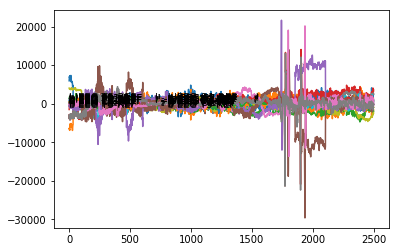

In [26]:
plotEDF(trainingEDF1,longBipolarMontage,0,10)